In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


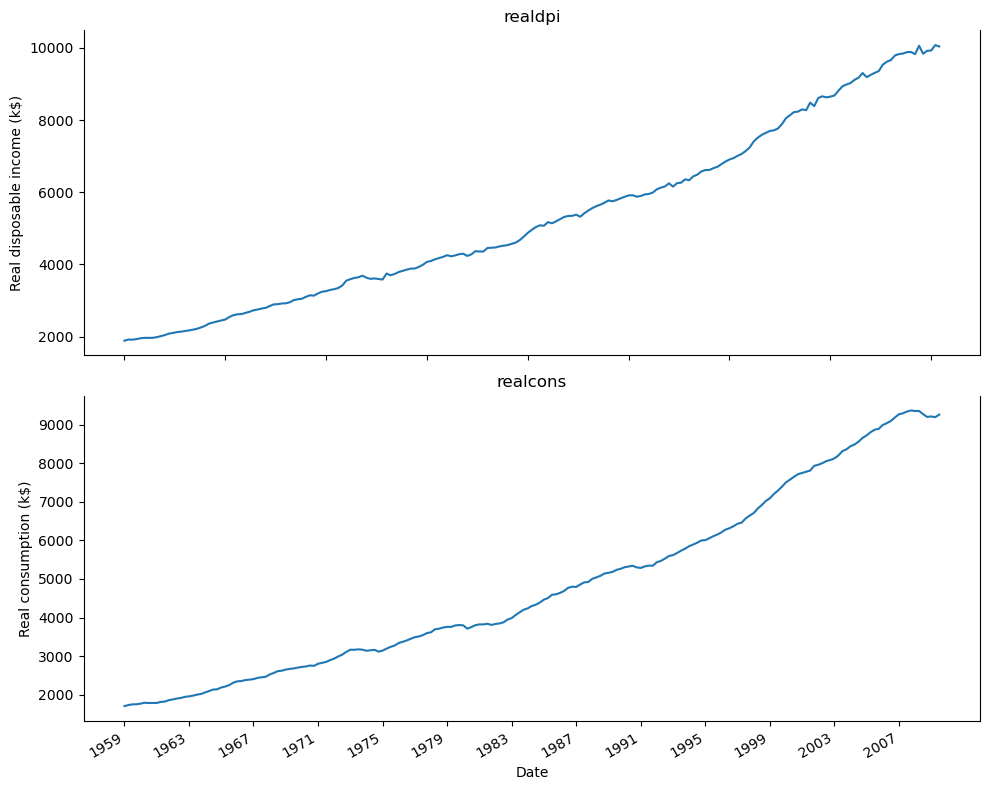

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

# VAR (vector autoregression)

In [64]:
# In this model, each series has an impact on the other,
# unlike the SARIMAX model where the exogenous variable had an impact on the target,
# but not the other way around.

# The VAR model can be seen as a generalization of the AR(p) model to allow for the forecast of multiple time series.

ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.9860253519546864
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050958
p-value: 0.9976992503412904


In [5]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673012
p-value: 1.449360615910768e-14

---------------------

realcons
ADF Statistic: -4.204306080845244
p-value: 0.000647928215862764


In [6]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [7]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070083
1,5,3123.708523
2,6,3126.855599
3,4,3129.194050
4,2,3130.091668
5,7,3133.395706
6,1,3134.333343
7,8,3137.149010
8,9,3140.367175
9,10,3147.839028


In [66]:
# we must now use the Granger causality test
# Recall that the VAR model assumes that past values of realcons are useful in predicting 
# realdpi and that past values of realdpi are useful in predicting realcons. This
# relationship must be tested. If the Granger causality test returns a p-value greater than
# 0.05, we cannot reject the null hypothesis, meaning that the variables do not Granger
# cause each other, and the model is invalid. On the other hand, a p-value smaller than
# 0.05 will allow us to reject the null hypothesis, thus validating the VAR(3) model,
# meaning that we can move on with the modeling procedure.

print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

# The [3] specifies the lag length for the Granger causality test. 
# It's telling the test to check if past values up to 3 periods ago help predict the current value.

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [67]:
# Running the Granger causality test for both variables returns a p-value smaller than
# 0.05 in both cases. Therefore, we can reject the null hypothesis and conclude that
# realdpi Granger-causes realcons, and realcons Granger-causes realdpi. Our
# VAR(3) model is thus valid. In the event that one variable does not Granger-cause the
# other, the VAR(p) model becomes invalid, and it cannot be used. In that case, we must
# use the SARIMAX model and predict each time series individually. 

best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Sun, 21 Sep 2025   BIC                           3175.559
Time:                             14:03:16   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

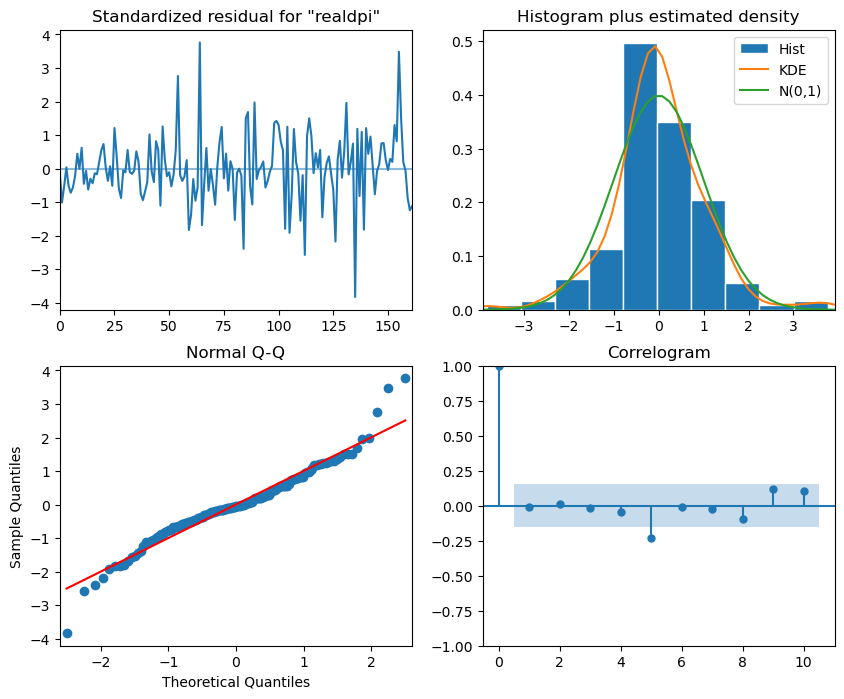

In [10]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

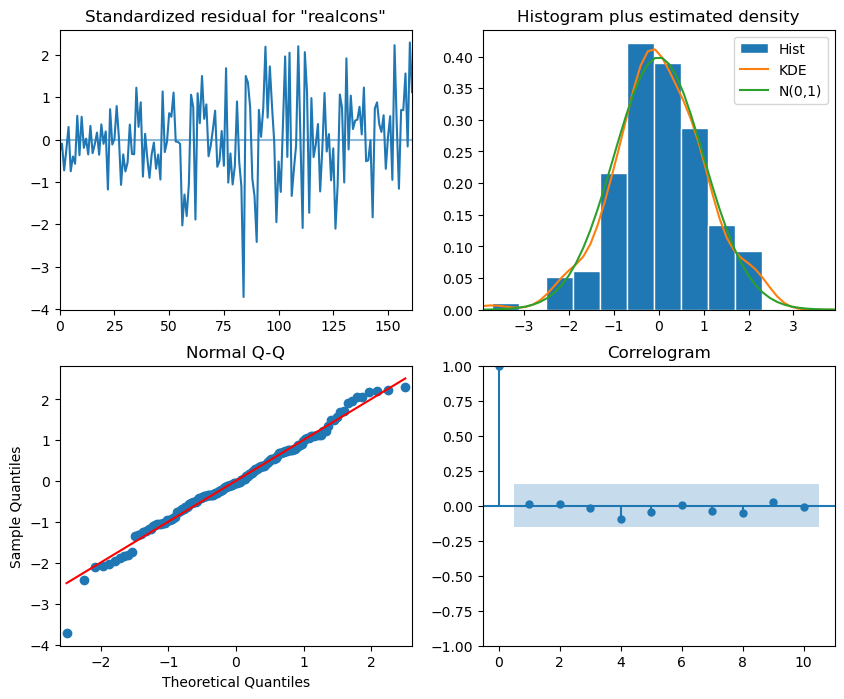

In [11]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [14]:
realgdp_residuals = best_model_fit.resid['realdpi']

lb_results = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11, 1))

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

LB Statistics:
1      0.011632
2      0.029373
3      0.075802
4      0.377883
5      9.142377
6      9.165206
7      9.269957
8     10.811360
9     13.317964
10    15.287250
Name: lb_stat, dtype: float64

P-values:
1     0.914115
2     0.985421
3     0.994574
4     0.984247
5     0.103518
6     0.164498
7     0.233851
8     0.212619
9     0.148739
10    0.121935
Name: lb_pvalue, dtype: float64


In [68]:
realcons_residuals = best_model_fit.resid['realcons']

lb_results = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11, 1))

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])


# Running the Ljung-Box test on the residuals of realdpi returns p-values that are all
# larger than 0.05. Thus, we do not reject the null hypothesis, meaning that the residuals
# are uncorrelated and independent, just like white noise.

LB Statistics:
1     0.023943
2     0.068706
3     0.068782
4     0.235733
5     0.377838
6     0.787350
7     1.015316
8     2.150482
9     2.437169
10    2.442830
Name: lb_stat, dtype: float64

P-values:
1     0.877030
2     0.966230
3     0.995300
4     0.993576
5     0.995918
6     0.992409
7     0.994578
8     0.976047
9     0.982526
10    0.991683
Name: lb_pvalue, dtype: float64


In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

In [21]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.221706,7354.323544
164,8053.4,7501.3,7897.184350,7430.253261
165,8135.9,7571.8,7960.557441,7496.626789
166,8222.3,7645.9,8014.749891,7556.611952
167,8234.6,7713.5,8080.698906,7630.995280
168,8296.5,7744.3,8142.391231,7692.844419
169,8273.7,7773.5,8200.125149,7753.865090
170,8484.5,7807.7,8259.366370,7812.534121
171,8385.5,7930.0,8264.390363,7864.634721
172,8611.6,7957.3,8320.862678,7895.059469


In [22]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.221706,7354.323544,7716.0,7199.9
164,8053.4,7501.3,7897.184350,7430.253261,7716.0,7199.9
165,8135.9,7571.8,7960.557441,7496.626789,7716.0,7199.9
166,8222.3,7645.9,8014.749891,7556.611952,7716.0,7199.9
167,8234.6,7713.5,8080.698906,7630.995280,8135.9,7571.8
168,8296.5,7744.3,8142.391231,7692.844419,8135.9,7571.8
169,8273.7,7773.5,8200.125149,7753.865090,8135.9,7571.8
170,8484.5,7807.7,8259.366370,7812.534121,8135.9,7571.8
171,8385.5,7930.0,8264.390363,7864.634721,8273.7,7773.5
172,8611.6,7957.3,8320.862678,7895.059469,8273.7,7773.5


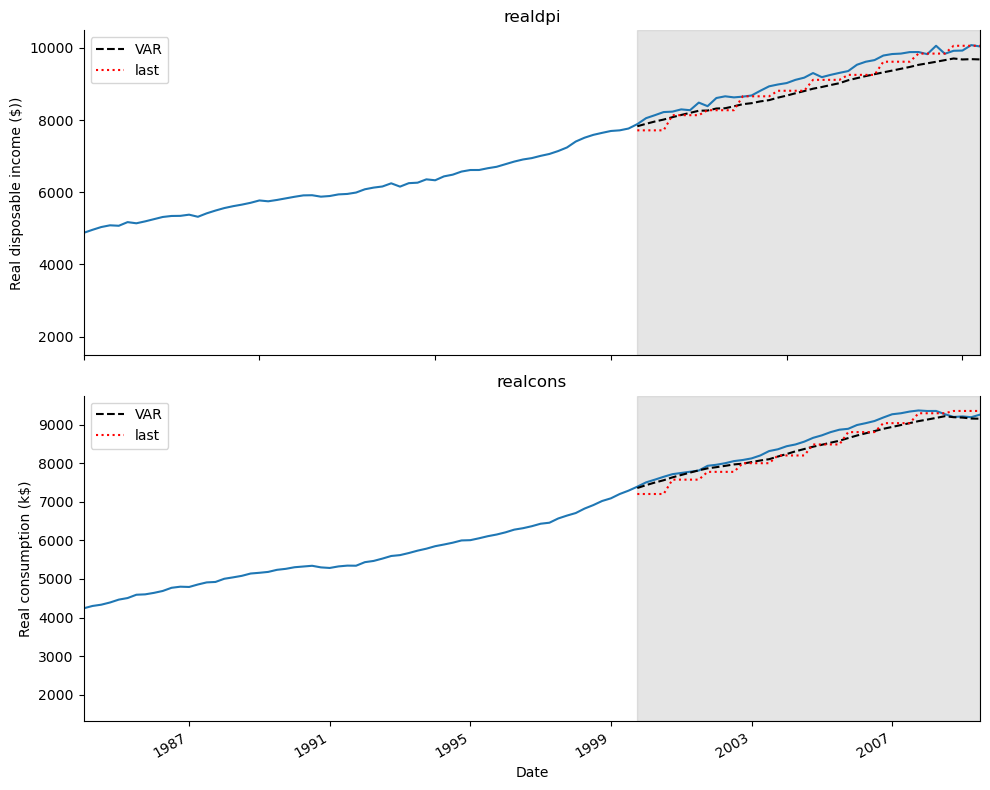

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

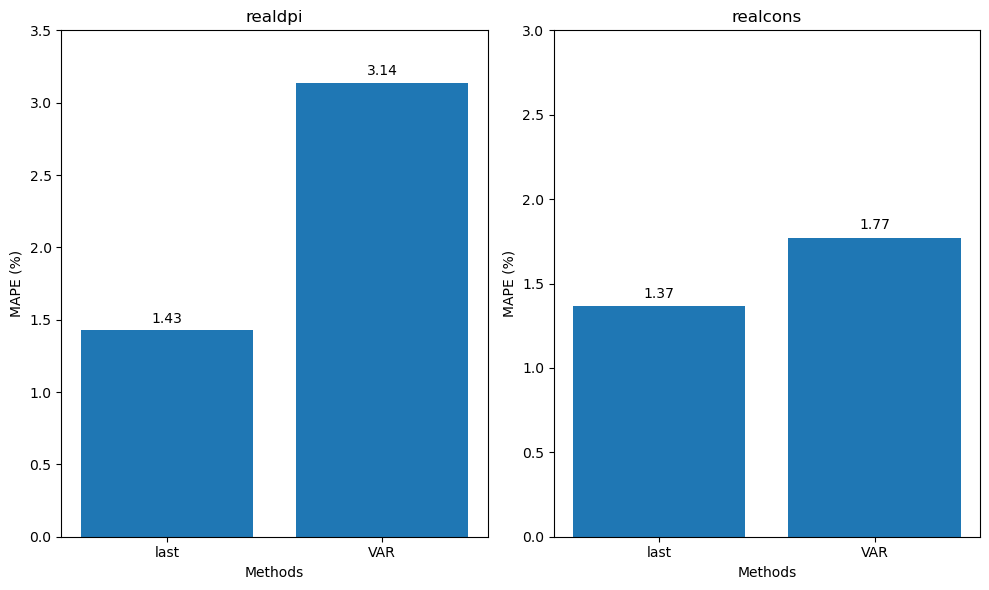

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

# you can see that the VAR(3) model performs worse than the baseline in
# the case of realdpi but better than the baseline for realcons. This is an ambiguous
# situation. There is no clear result, since the model does not outperform the baseline
# in both situations.
# We can hypothesize that in the case of realdpi, realcons is not predictive enough
# to make more accurate forecasts than the baseline, even though the Granger causality
# test passed. Therefore, we should resort to using a variation of the SARIMAX model to
# predict realdpi. Thus, I would conclude that the VAR(3) model is not sufficient to
# accurately forecast realdpi and realcons. I would suggest using two separate models,
# which could include realdpi and realcons as exogenous variables, while also 
# potentially including moving average terms.

# Exercises

## Use a VARMA model to predict realdpi and realcons 

In [27]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


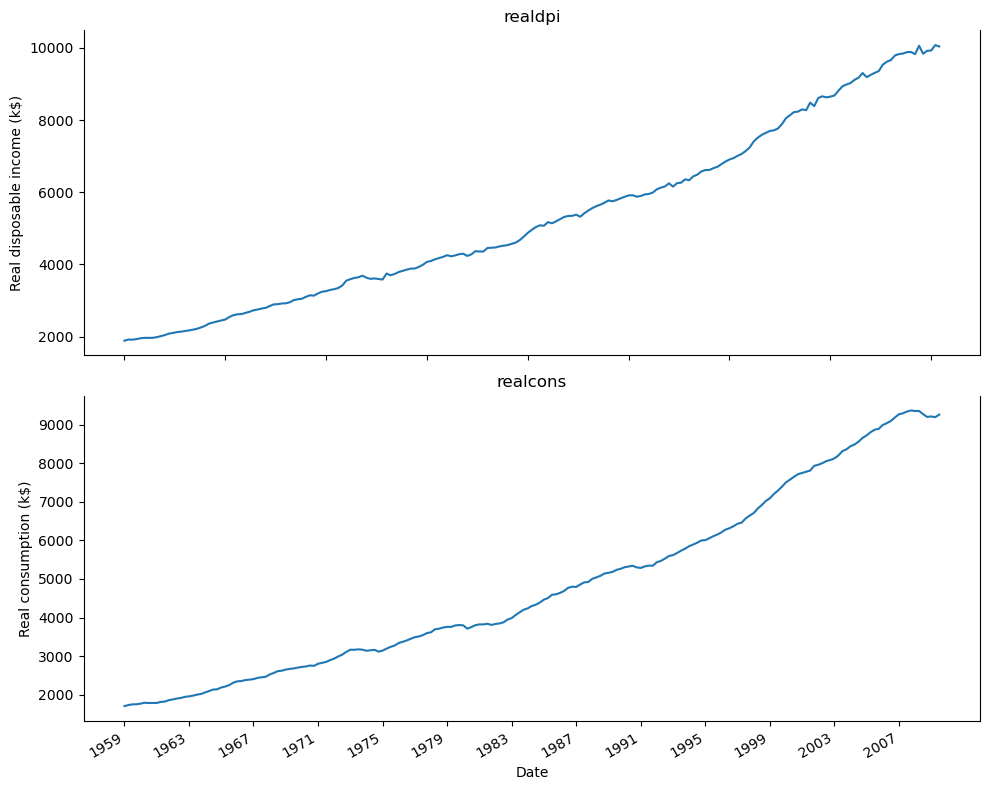

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [29]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

# Both series are not statioanry. Let's try differencing.

realdpi
ADF Statistic: 2.9860253519546864
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050958
p-value: 0.9976992503412904


In [30]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

# Both series are now stationary. We can start modeling!

realdpi
ADF Statistic: -8.864893340673012
p-value: 1.449360615910768e-14

---------------------

realcons
ADF Statistic: -4.204306080845244
p-value: 0.000647928215862764


In [31]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding AIC
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [32]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMA = optimize_VARMA(train, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 0)",3123.070083
1,"(2, 1)",3124.094763
2,"(1, 3)",3125.196710
3,"(3, 2)",3125.451761
4,"(2, 3)",3125.779614
5,"(1, 2)",3126.989589
6,"(3, 1)",3129.009464
7,"(1, 1)",3129.188601
8,"(2, 2)",3129.938805
9,"(2, 0)",3130.091668


In [33]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [34]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Sun, 21 Sep 2025   BIC                           3175.559
Time:                             11:21:59   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

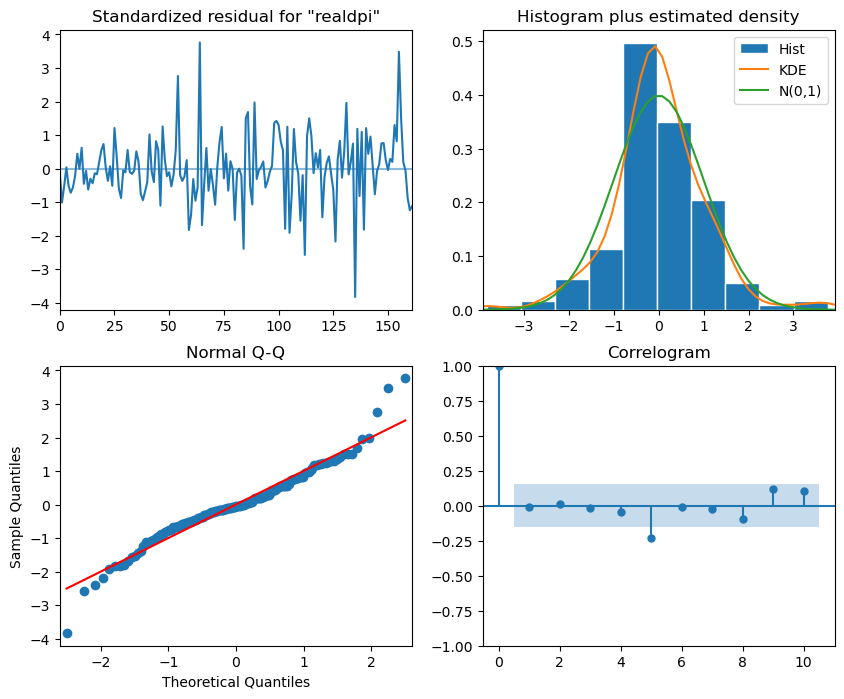

In [35]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

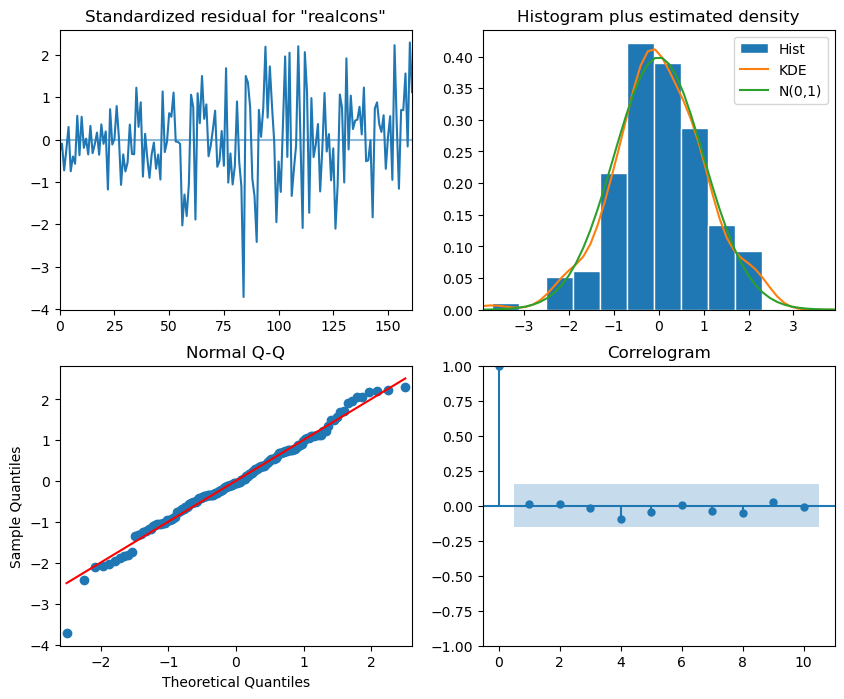

In [36]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [37]:
realgdp_residuals = best_model_fit.resid['realdpi']

lb_results = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11, 1))

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

LB Statistics:
1      0.011632
2      0.029373
3      0.075802
4      0.377883
5      9.142377
6      9.165206
7      9.269957
8     10.811360
9     13.317964
10    15.287250
Name: lb_stat, dtype: float64

P-values:
1     0.914115
2     0.985421
3     0.994574
4     0.984247
5     0.103518
6     0.164498
7     0.233851
8     0.212619
9     0.148739
10    0.121935
Name: lb_pvalue, dtype: float64


In [38]:
realcons_residuals = best_model_fit.resid['realcons']

lb_results = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11, 1))

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

LB Statistics:
1     0.023943
2     0.068706
3     0.068782
4     0.235733
5     0.377838
6     0.787350
7     1.015316
8     2.150482
9     2.437169
10    2.442830
Name: lb_stat, dtype: float64

P-values:
1     0.877030
2     0.966230
3     0.995300
4     0.993576
5     0.995918
6     0.992409
7     0.994578
8     0.976047
9     0.982526
10    0.991683
Name: lb_pvalue, dtype: float64


In [39]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMA':

        realdpi_pred_VARMA = []
        realcons_pred_VARMA = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMA.extend(oos_pred_realdpi)
            realcons_pred_VARMA.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMA, realcons_pred_VARMA
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [40]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VARMA, realcons_pred_VARMA = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMA')

In [41]:
test = endog[163:]

test['realdpi_pred_VARMA'] = pd.Series()
test['realdpi_pred_VARMA'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMA)

test['realcons_pred_VARMA'] = pd.Series()
test['realcons_pred_VARMA'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMA)

In [42]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [43]:
test.head()

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.221706,7354.323544,7716.0,7199.9
164,8053.4,7501.3,7897.184350,7430.253261,7716.0,7199.9
165,8135.9,7571.8,7960.557441,7496.626789,7716.0,7199.9
166,8222.3,7645.9,8014.749891,7556.611952,7716.0,7199.9
167,8234.6,7713.5,8080.698906,7630.995280,8135.9,7571.8


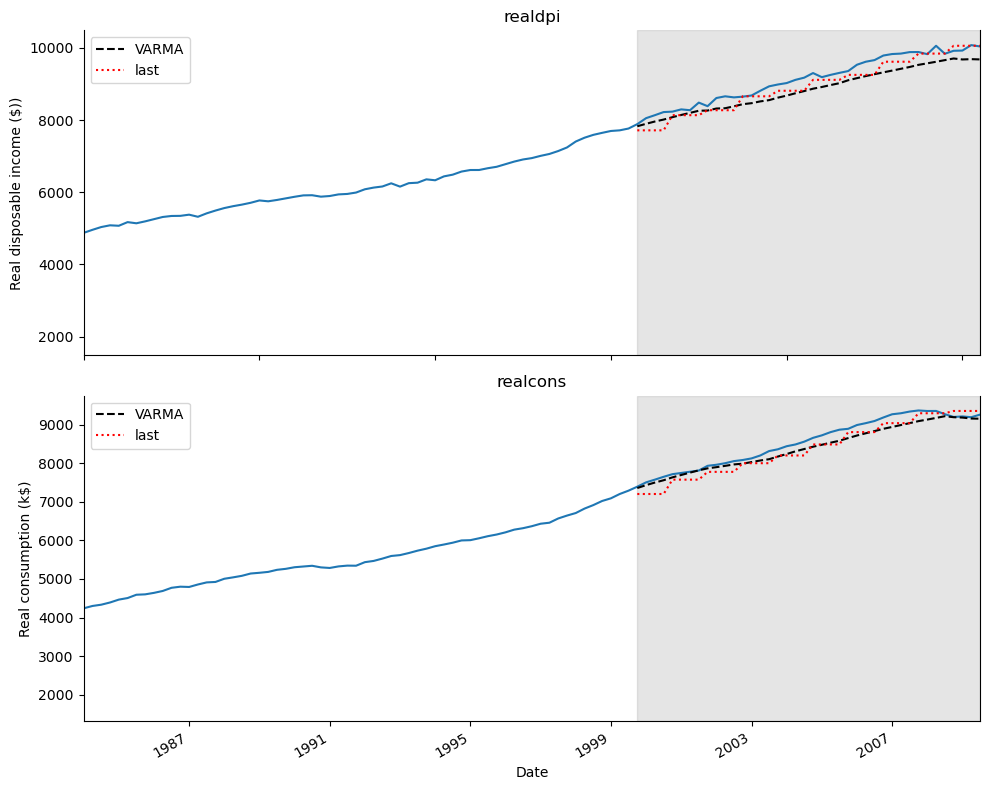

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VARMA'], 'k--', label='VARMA')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VARMA'], 'k--', label='VARMA')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
mape_realdpi_VARMA = mape(test['realdpi'], test['realdpi_pred_VARMA'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMA = mape(test['realcons'], test['realcons_pred_VARMA'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

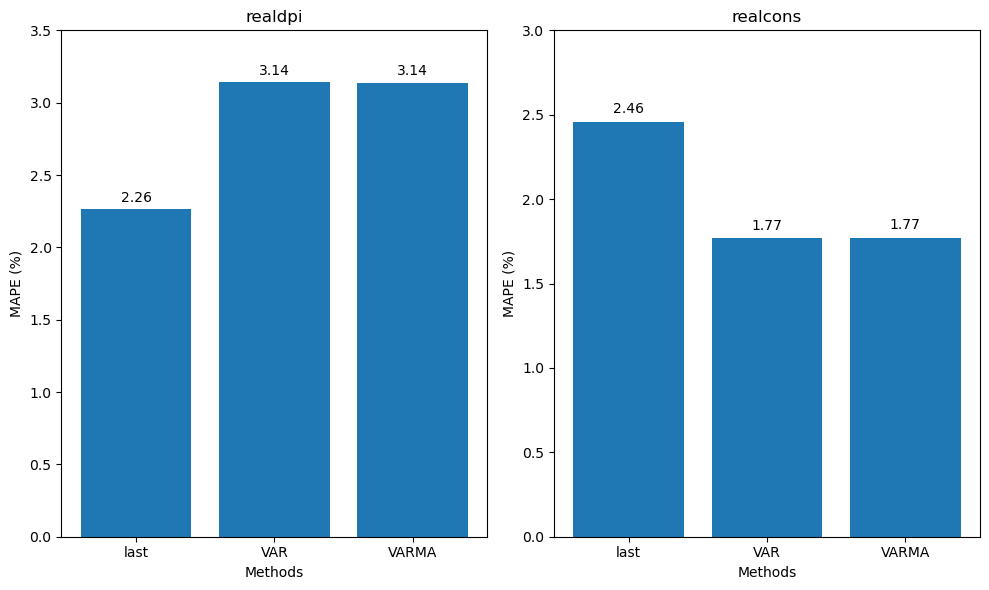

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR', 'VARMA']
y1 = [mape_realdpi_last, 3.14, mape_realdpi_VARMA]    # From chapter 10, VAR model achieved a MAPE of 3.14%
y2 = [mape_realcons_last, 1.77, mape_realcons_VARMA]  # From chapter 10, VAR model achieved a MAPE of 1.77%

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

# Using a VARMA model did not change anything, since the VARMA(3,0) 
# achieved the lowest AIC, which is equivalent to a VAR(3) model,just like before.
# Let's try a VARMAX model to see if we can get an improvement.

## Use a VARMAX model to predict realdpi and realcons

In [48]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Returns a dataframe with (p,q) and AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [49]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Select the exogenous variables. Note that they do not be to be stationary to be used
exog_cols = macro_econ_data.columns.drop(['year', 'quarter', 'realdpi', 'realcons'])
# Make sure that the index of exog is aligned with train
exog = macro_econ_data[exog_cols][1:163]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMAX = optimize_VARMAX(train, exog, parameters_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 0)",3113.478554
1,"(0, 1)",3117.326744
2,"(2, 0)",3118.688860
3,"(1, 1)",3119.158963
4,"(3, 0)",3121.521262
5,"(0, 3)",3122.398468
6,"(0, 2)",3123.637263
7,"(1, 2)",3125.051543
8,"(2, 1)",3125.652016
9,"(1, 3)",3126.778631


In [50]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [1])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [1])

# The p-value for "realdpi Granger-causes realcons" is only very slightly larger than 0.05. Thus, we decide to move forward with the model.

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1


In [51]:
best_model = VARMAX(train, exog, order=(1,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                             VARX(1)   Log Likelihood               -1527.739
                               + intercept   AIC                           3113.479
Date:                     Sun, 21 Sep 2025   BIC                           3203.019
Time:                             11:30:49   HQIC                          3149.833
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.08, 0.29   Jarque-Bera (JB):         40.65, 18.60
Prob(Q):                        0.78, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         5.81, 2.63   Skew:                      0.12

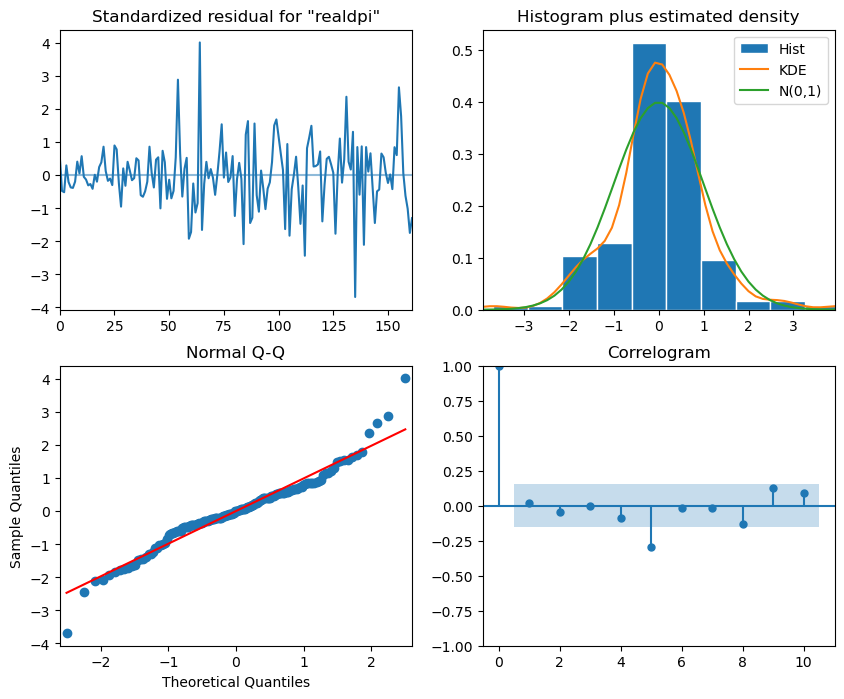

In [52]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

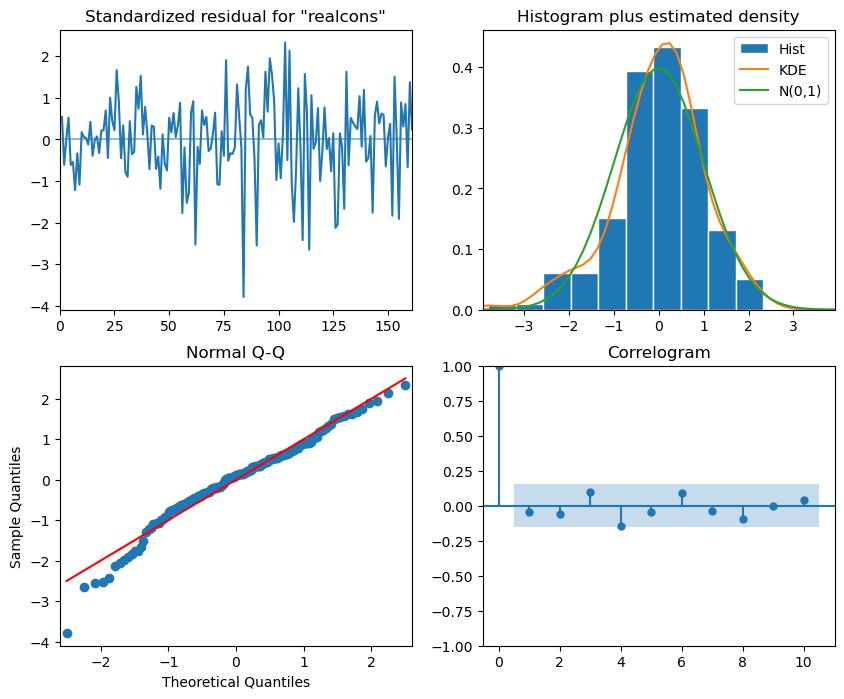

In [53]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [54]:
realgdp_residuals = best_model_fit.resid['realdpi']

lb_results = acorr_ljungbox(realgdp_residuals, lags=np.arange(1, 11, 1))

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

# Here, we see that the p-value is less than 0.05 starting at lag 5. 
# This is worrying becasue it seems that the residuals of realdpi are correlated starting at lag 5. 
# let's keep going, especially becasue the visual inspection of the residuals all point to the conclusion 
# that the residuals behave like white noise.

# You can see that sometimes, there is a bit of judgement to be made when we are in a grey zone.

LB Statistics:
1      0.075852
2      0.410878
3      0.411432
4      1.786817
5     16.201097
6     16.266712
7     16.307532
8     19.254974
9     21.970168
10    23.465730
Name: lb_stat, dtype: float64

P-values:
1     0.782999
2     0.814290
3     0.937871
4     0.774893
5     0.006293
6     0.012392
7     0.022451
8     0.013554
9     0.008974
10    0.009152
Name: lb_pvalue, dtype: float64


In [55]:
realcons_residuals = best_model_fit.resid['realcons']

lb_results = acorr_ljungbox(realcons_residuals, lags=np.arange(1, 11, 1))

# Access the columns you want
print("LB Statistics:")
print(lb_results['lb_stat'])
print("\nP-values:")
print(lb_results['lb_pvalue'])

LB Statistics:
1      0.266405
2      2.018774
3      6.832882
4      9.590095
5     11.190506
6     13.392151
7     13.693102
8     17.968949
9     17.969399
10    18.220139
Name: lb_stat, dtype: float64

P-values:
1     0.605754
2     0.364442
3     0.077420
4     0.047929
5     0.047731
6     0.037214
7     0.056917
8     0.021460
9     0.035530
10    0.051362
Name: lb_pvalue, dtype: float64


In [56]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMAX':

        realdpi_pred_VARMAX = []
        realcons_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], exog[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])    # Use the exogenous variable to 
                                                                                       # generate predictions
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMAX.extend(oos_pred_realdpi)
            realcons_pred_VARMAX.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMAX, realcons_pred_VARMAX
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [57]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # We can only predict the next timestep, since we have exogenous variables (just like the SARIMAX model)

exog = macro_econ_data[exog_cols][1:]

realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

In [58]:
test = endog[163:]

test['realdpi_pred_VARMAX'] = pd.Series()
test['realdpi_pred_VARMAX'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMAX)

test['realcons_pred_VARMAX'] = pd.Series()
test['realcons_pred_VARMAX'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMAX)

In [59]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [60]:
test.head()

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7785.091732,7409.320799,7716.0,7199.9
164,8053.4,7501.3,7825.412405,7545.411368,7765.9,7286.4
165,8135.9,7571.8,7870.442169,7682.900227,7887.7,7389.2
166,8222.3,7645.9,7903.713283,7809.630690,8053.4,7501.3
167,8234.6,7713.5,7941.782680,7935.351725,8135.9,7571.8


In [61]:
mape_realdpi_VARMAX = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMAX = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

In [62]:
print(mape_realdpi_VARMAX)

11.258741660405022


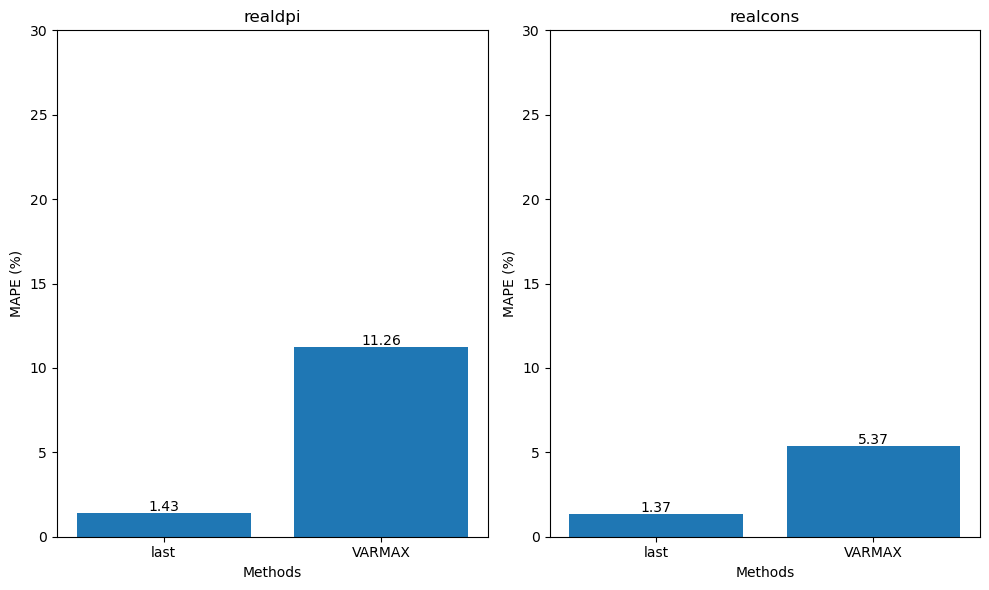

In [63]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VARMAX']
y1 = [mape_realdpi_last, mape_realdpi_VARMAX]   
y2 = [mape_realcons_last, mape_realcons_VARMAX] 

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 30)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 30)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()

# Clearly, using a VARMAX model is a very bad idea in this situation, since it achieves a very high MAPE compared to a simple baseline. 
# Note that we cannot compare this performance to the VAR and VARMA models, since the forecast window is different for VARMAX.

In [70]:
# Summary

# The vector autoregression model, VAR(p), captures the relationship between
# multiple series as they change over time. In this model, each series has an impact
# on the others.
 
# A VAR(p) model is valid only if each time series Granger-causes the others. This
# is determined using the Granger causality test.
 
# The null hypothesis of the Granger causality test states that one time series does
# not Granger-cause the other. If the p-value is less than 0.05, we reject the null
# hypothesis and conclude that the first time series Granger-causes the other.